<a href="https://colab.research.google.com/github/AIBYTECH/Computer-vision/blob/main/cancer%20detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

100% 3.09G/3.10G [00:18<00:00, 122MB/s]
100% 3.10G/3.10G [00:18<00:00, 180MB/s]


In [ ]:
!unzip /content/breast-histopathology-images.zip -d new_1

Streaming output truncated to the last 5000 lines.
  inflating: new_1/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1551_class0.png  
  inflating: new_1/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: new_1/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: new_1/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: new_1/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: new_1/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: new_1/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: new_1/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: new_1/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.png  
  inflating: new_1/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2001_class0.png  
  inflating: new_1/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2251_class0.png  
  inflating: new_1/IDC_regular_ps50_

In [ ]:
from numpy.random import seed
import tensorflow as tf
tf.compat.v1.set_random_seed(101)

import pandas as pd
import numpy as np

import tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os
import cv2
import imageio
import skimage
import skimage.io
import skimage.transform

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Number of samples we want in each class.Total images used = SAMPLE_SIZE X 2
# The minority class is class 1 with 78786 samples.

SAMPLE_SIZE = 78786

IMAGE_SIZE = 50

In [ ]:
os.listdir('../content/new_1/IDC_regular_ps50_idx5')

['12751',
 '8974',
 '9382',
 '12877',
 '9135',
 '9322',
 '10278',
 '10255',
 '14209',
 '9037',
 '12883',
 '12933',
 '8956',
 '12750',
 '12749',
 '8959',
 '10292',
 '9256',
 '9226',
 '10293',
 '14211',
 '16896',
 '13691',
 '12932',
 '9383',
 '12869',
 '9081',
 '13018',
 '13106',
 '10304',
 '9260',
 '12951',
 '10285',
 '8914',
 '12898',
 '16532',
 '10307',
 '10274',
 '15903',
 '10260',
 '12911',
 '13458',
 '13617',
 '9325',
 '15472',
 '12894',
 '12948',
 '10275',
 '8984',
 '8867',
 '12819',
 '10253',
 '14082',
 '9173',
 '10295',
 '10291',
 '8864',
 '12870',
 '10288',
 '9177',
 '10303',
 '8950',
 '9323',
 '12873',
 '10300',
 '10264',
 '15512',
 '13692',
 '14156',
 '14191',
 '12897',
 '14190',
 '10272',
 '12817',
 '10259',
 '15840',
 '12929',
 '12752',
 '9029',
 '12949',
 '13020',
 '9321',
 '12893',
 '14212',
 '12811',
 '14154',
 '9291',
 '9022',
 '9124',
 '16165',
 '13689',
 '10276',
 '13019',
 '12955',
 '12822',
 '14188',
 '9078',
 '13666',
 '9178',
 '10262',
 '14210',
 '9267',
 '12900',

In [ ]:
# Check the number of patient folders.

patients = os.listdir('../content/new_1/IDC_regular_ps50_idx5')

len(patients)

279

In [ ]:
# Create a new directory to store all available images
all_images_dir = 'all_images_dir'
os.mkdir(all_images_dir)

In [ ]:
# check that the new diectory has been created
!ls

all_images_dir			  kaggle.json  sample_data
breast-histopathology-images.zip  new_1


In [ ]:
# This code copies all images from their seperate folders into the same 
# folder called all_images_dir.

# Create a list with all the patient id numbers.
# Each patient id folder has 2 sub folders --> folder 0 and folder 1

# Example:
    # '10285'
        # '0'
        # '1'

# create a list of all patient id's
patient_list = os.listdir('../content/new_1/IDC_regular_ps50_idx5')

for patient in patient_list:
  path_0 = '../content/new_1/IDC_regular_ps50_idx5/' + str(patient) + '/0'
  path_1 = '../content/new_1/IDC_regular_ps50_idx5/' + str(patient) + '/1'


    # create a list of all files in folder 0
  file_list_0 = os.listdir(path_0)
    # create a list of list all file in folder 1
  file_list_1 = os.listdir(path_1)

    # move the 0 images to all_images_dir
  for fname in file_list_0:
    # source path to image
    src = os.path.join(path_0, fname)
    # destination path to image
    dst = os.path.join(all_images_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


    # move the 1 images to all_images_dir
  for fname in file_list_1:
    # source path to image
    src = os.path.join(path_1, fname)
    # destination path to image
    dst = os.path.join(all_images_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [ ]:
# check how many images are in all_images_dir
# should be 277,524

# size: 2.5GB

len(os.listdir('all_images_dir'))

277524

**Create a dataframe containing all the information**

In [ ]:
image_list = os.listdir('all_images_dir')

df_data = pd.DataFrame(image_list, columns=['image_id'])

df_data.head()

,image_id
0,10279_idx5_x2301_y751_class0.png
1,9265_idx5_x1751_y451_class0.png
2,13019_idx5_x3151_y1301_class0.png
3,10272_idx5_x3051_y601_class0.png
4,9323_idx5_x151_y1351_class0.png


In [ ]:
# Define Helper Functions

# Each file name has this format:
# '14211_idx5_x2401_y1301_class1.png'

def extract_patient_id(x):
    # split into a list
    a = x.split('_')
    # the id is the first index in the list
    patient_id = a[0]
    
    return patient_id

def extract_target(x):
    # split into a list
    a = x.split('_')
    # the target is part of the string in index 4
    b = a[4]
    # the ytarget i.e. 1 or 2 is the 5th index of the string --> class1
    target = b[5]
    return target

# extract the patient id

# create a new column called 'patient_id'
df_data['patient_id'] = df_data['image_id'].apply(extract_patient_id)
# create a new column called 'target'
df_data['target'] = df_data['image_id'].apply(extract_target)

df_data.head(10)

,image_id,patient_id,target
0,10279_idx5_x2301_y751_class0.png,10279,0
1,9265_idx5_x1751_y451_class0.png,9265,0
2,13019_idx5_x3151_y1301_class0.png,13019,0
3,10272_idx5_x3051_y601_class0.png,10272,0
4,9323_idx5_x151_y1351_class0.png,9323,0
5,12891_idx5_x2951_y951_class0.png,12891,0
6,9382_idx5_x251_y1451_class0.png,9382,0
7,10258_idx5_x751_y1001_class1.png,10258,1
8,10277_idx5_x1001_y1701_class1.png,10277,1
9,9023_idx5_x651_y1701_class0.png,9023,0


In [ ]:
df_data.shape

(277524, 3)

In [ ]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['image_id']
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

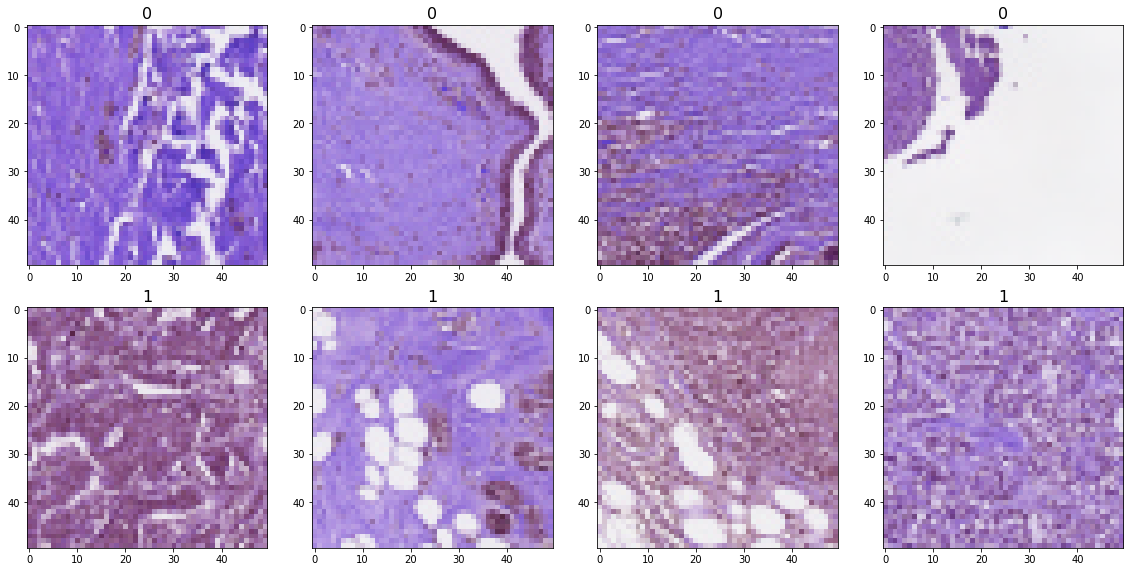

In [ ]:
IMAGE_PATH = 'all_images_dir/'

draw_category_images('target',4, df_data, IMAGE_PATH)

In [ ]:
# What is the class distribution?

df_data['target'].value_counts()

0    198738
1     78786
Name: target, dtype: int64

In [ ]:
df_data['target']

0         0
1         0
2         0
3         0
4         0
         ..
277519    0
277520    1
277521    1
277522    0
277523    0
Name: target, Length: 277524, dtype: object

In [ ]:
# take a sample of the majority class 0 (total = 198738)
#SAMPLE_SIZE = 198738
df_0 = df_data[df_data['target'] == '0'].sample(SAMPLE_SIZE, random_state=101)
# take a sample of class 1 (total = 78786)
#SAMPLE_SIZE = 78786
df_1 = df_data[df_data['target'] == '1'].sample(SAMPLE_SIZE, random_state=101)
# concat the two dataframes
df_data_1 = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
# Check the new class distribution
df_data_1['target'].value_counts()

0    78786
1    78786
Name: target, dtype: int64

In [ ]:
# train_test_split

# stratify=y creates a balanced validation set.
y = df_data['target']

df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(249771, 3)
(27753, 3)


In [ ]:
df_train['target'].value_counts()

0    178864
1     70907
Name: target, dtype: int64

In [ ]:
df_val['target'].value_counts()

0    19874
1     7879
Name: target, dtype: int64

In [ ]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 2 folders inside 'base_dir':

# train_dir
    # a_no_idc
    # b_has_idc

# val_dir
    # a_no_idc
    # b_has_idc




# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
a_no_idc = os.path.join(train_dir, 'a_no_idc')
os.mkdir(a_no_idc)
b_has_idc = os.path.join(train_dir, 'b_has_idc')
os.mkdir(b_has_idc)



# create new folders inside val_dir
a_no_idc = os.path.join(val_dir, 'a_no_idc')
os.mkdir(a_no_idc)
b_has_idc = os.path.join(val_dir, 'b_has_idc')
os.mkdir(b_has_idc)

In [ ]:
# check that the folders have been created
os.listdir('base_dir/train_dir')

['b_has_idc', 'a_no_idc']

In [ ]:
['a_no_idc', 'b_has_idc']

['a_no_idc', 'b_has_idc']

In [ ]:
# Set the id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [ ]:
# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer the train images

for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image
    # get the label for a certain image
    target = df_data.loc[image,'target']
    
    # these must match the folder names
    if target == '0':
        label = 'a_no_idc'
    if target == '1':
        label = 'b_has_idc'
    
    # source path to image
    src = os.path.join(all_images_dir, fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # move the image from the source to the destination
    shutil.move(src, dst)

 # Transfer the val images

for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image
    # get the label for a certain image
    target = df_data.loc[image,'target']
    
    # these must match the folder names
    if target == '0':
        label = 'a_no_idc'
    if target == '1':
        label = 'b_has_idc'
    # source path to image
    src = os.path.join(all_images_dir, fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # move the image from the source to the destination
    shutil.move(src, dst)  

In [ ]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/a_no_idc')))
print(len(os.listdir('base_dir/train_dir/b_has_idc')))

178864
70907


In [ ]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/a_no_idc')))
print(len(os.listdir('base_dir/val_dir/b_has_idc')))

19874
7879


In [ ]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'


num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 249771 images belonging to 2 classes.
Found 27753 images belonging to 2 classes.
Found 27753 images belonging to 2 classes.


**Create the Model Architecture¶**

In [ ]:

kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3

model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 conv2d_10 (Conv2D)          (None, 46, 46, 32)        9248      
                                                                 
 conv2d_11 (Conv2D)          (None, 44, 44, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 22, 22, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 20, 20, 64)        18496     
                                                      

In [ ]:
model.compile( optimizer=tf.optimizers.Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [ ]:
from keras.models import load_model

model.save('model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('model.h5')

In [ ]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=3, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]


history = model.fit(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=3, verbose=1,
                   callbacks=callbacks_list)


Epoch 1/3
24978/24978 [==============================] - ETA: 0s - loss: 0.5966 - accuracy: 0.7161

24978/24978 [==============================] - 5428s 217ms/step - loss: 0.5966 - accuracy: 0.7161 - val_loss: 0.5966 - val_accuracy: 0.7161 - lr: 1.0000e-04
Epoch 2/3
24978/24978 [==============================] - ETA: 0s - loss: 0.5966 - accuracy: 0.7161

24978/24978 [==============================] - 5241s 210ms/step - loss: 0.5966 - accuracy: 0.7161 - val_loss: 0.5966 - val_accuracy: 0.7161 - lr: 1.0000e-04
Epoch 3/3
24978/24978 [==============================] - ETA: 0s - loss: 0.5966 - accuracy: 0.7161

24978/24978 [==============================] - 5351s 214ms/step - loss: 0.5966 - accuracy: 0.7161 - val_loss: 0.5966 - val_accuracy: 0.7161 - lr: 1.0000e-04


In [ ]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'accuracy']

In [ ]:
# Here the best epoch will be used.

model.load_weights('model.h5')

val_loss, val_acc = \
model.evaluate_generator(test_gen, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

<ipython-input-78-28bf2f308882>:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_gen,


val_loss: 0.5966112017631531
val_acc: 0.7161027789115906


In [ ]:
# make a prediction
predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

    1/27753 [..............................] - ETA: 1:10:19

<ipython-input-79-94026f275592>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)


27753/27753 [==============================] - 278s 10ms/step


In [ ]:
predictions.shape

(27753, 2)

In [ ]:
# This is how to check what index keras has internally assigned to each class. 
test_gen.class_indices

{'a_no_idc': 0, 'b_has_idc': 1}

In [ ]:
# Put the predictions into a dataframe.
# The columns need to be oredered to match the output of the previous cell

df_preds = pd.DataFrame(predictions, columns=['no_idc', 'has_idc'])

df_preds.head()

,no_idc,has_idc
0,0.863639,0.136361
1,0.863639,0.136361
2,0.863639,0.136361
3,0.863639,0.136361
4,0.863639,0.136361


In [ ]:
# Get the true labels
y_true = test_gen.classes

# Get the predicted labels as probabilities
y_pred = df_preds['has_idc']

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true, y_pred)

0.5

In [ ]:
# Get the labels of the test images.

test_labels = test_gen.classes

In [ ]:
test_labels.shape

(27753,)

In [ ]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [ ]:
# Print the label associated with each class
test_gen.class_indices

{'a_no_idc': 0, 'b_has_idc': 1}

In [ ]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt  